# Data Analysis

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

# Configuration
sns.set_style("whitegrid")
sns.set_context("notebook")

### Tables


In [4]:
# 1. Load Data
# We manually define header names based on the prompt description as the CSV might lack them or have specific ordering.
column_names = [
    "reference", "location", "price", "title", "bedrooms", 
    "bathrooms", "indoor_surface", "outdoor_surface", "features"
]

df = pd.read_csv("data/properties.csv", header=None, names=column_names, na_values="NA")

# 2. Data Cleaning
# Price column contains '€' and commas. We must clean this to make it continuous.
df['price'] = df['price'].astype(str).str.replace('€', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Ensure other numeric columns are treated as numbers (handling potential string 'NA's)
numeric_cols = ['bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display basic info
display(df.columns)
display(df.head())

# 3. Define Variable Types
# Categorical
categoricalFeatures = ["location", "title", "features"] # Reference is an ID, usually excluded from analysis
display(categoricalFeatures)

# Continuous
continuousFeatures = ["price", "bedrooms", "bathrooms", "indoor_surface", "outdoor_surface"]
display(continuousFeatures)

Index(['reference', 'location', 'price', 'title', 'bedrooms', 'bathrooms',
       'indoor_surface', 'outdoor_surface', 'features'],
      dtype='object')

,reference,location,price,title,bedrooms,bathrooms,indoor_surface,outdoor_surface,features
0,R126116,"Nueva Andalucía, Costa del Sol",450000,3 Bedroom Apartment,3.0,2.0,120.0,NaN,Close to Shops|Electricity Utilities|Close to ...
1,R132516,"Puerto Banús, Costa del Sol",1250000,Other,1.0,504.0,NaN,NaN,Electricity Utilities|Close to Town|Street Vie...
2,R121563,"Antequera, Costa del Sol",749000,12 Bedroom Finca,12.0,7.0,366.0,5353.0,Mountain Views|Private Garden|Open Parking|Urb...
3,R127293,"La Mairena, Costa del Sol",500000,Plot,3470.0,NaN,NaN,NaN,Mountain Views|Private Garden|Electricity Util...
4,R114041,"Benalmadena, Costa del Sol",1695000,4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,Private Garden|Electricity Utilities|Drinkable...


['location', 'title', 'features']

['price', 'bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']

### Continuous Summary

In [5]:
continuous_summary = df[continuousFeatures].describe(include='all').T
continuous_summary['cardinality'] = df[continuousFeatures].nunique()
continuous_summary['missing_%'] = (df[continuousFeatures].isnull().sum() / len(df)) * 100

continuous_summary = continuous_summary.rename(columns={
    'count': 'total_number_of_values',
    '25%': '1st_quartile',
    '50%': 'median',
    '75%': '3rd_quartile',
    'min': 'minimum',
    'max': 'maximum',
    'std': 'standard_deviation'
})

display(continuous_summary)

,total_number_of_values,mean,standard_deviation,minimum,1st_quartile,median,3rd_quartile,maximum,cardinality,missing_%
price,12086.0,1.046977e+06,1.881298e+06,4500.0,285000.0,475000.0,995000.00,50000000.0,1717,0.000000
bedrooms,12084.0,2.533518e+03,9.853142e+04,0.0,2.0,3.0,5.00,9700000.0,904,0.016548
bathrooms,10952.0,1.076485e+03,4.636483e+04,0.0,2.0,2.0,4.00,4630000.0,453,9.382757
indoor_surface,10414.0,2.334892e+02,2.650649e+02,10.0,100.0,144.5,268.75,5367.0,923,13.834188
outdoor_surface,3821.0,1.113215e+04,1.960650e+05,1.0,401.0,1009.0,2342.00,9350000.0,1797,68.384908


### Categorical Summary

In [6]:
categorical_summary_list = []

for feature in categoricalFeatures:
    total_values = df[feature].count()
    missing_percentage = (df[feature].isnull().sum() / len(df)) * 100
    cardinality = df[feature].nunique()
    value_counts = df[feature].value_counts()
    
    # Mode 1
    if not value_counts.empty:
        mode_1 = value_counts.index[0]
        mode_1_freq = value_counts.iloc[0]
        mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
    else:
        mode_1 = 'N/A'; mode_1_freq = 0; mode_1_perc = 0
    
    # Mode 2
    if cardinality > 1:
        mode_2 = value_counts.index[1]
        mode_2_freq = value_counts.iloc[1]
        mode_2_perc = (mode_2_freq / total_values) * 100 if total_values > 0 else 0
    else:
        mode_2 = 'N/A'
        mode_2_freq = 'N/A'
        mode_2_perc = 'N/A'
        
    categorical_summary_list.append({
        'total_number_of_values': total_values,
        'missing_%': missing_percentage,
        'cardinality': cardinality,
        'mode': mode_1,
        'mode_frequency': mode_1_freq,
        'mode_percentage': mode_1_perc,
        'mode_2': mode_2,
        'mode_2_frequency': mode_2_freq,
        'mode_2_percentage': mode_2_perc
    })

categorical_summary = pd.DataFrame(categorical_summary_list, index=categoricalFeatures)

display(categorical_summary)

,total_number_of_values,missing_%,cardinality,mode,mode_frequency,mode_percentage,mode_2,mode_2_frequency,mode_2_percentage
location,12086,0.000000,226,"Estepona, Costa del Sol",1062,8.787026,"Nueva Andalucía, Costa del Sol",711,5.882840
title,12086,0.000000,160,2 Bedroom Apartment,2043,16.903856,3 Bedroom Apartment,1287,10.648684
features,11505,4.807215,11277,Mountain Views|Urbanisation|South Orientation|...,9,0.078227,Electricity Utilities|Drinkable Water Utilitie...,9,0.078227


### Data Issues

--- 1. Missing Values Check ---
Found missing values in the following columns:

                 Missing Values  % of Total Values
outdoor_surface            8265              68.38
indoor_surface             1672              13.83
bathrooms                  1134               9.38
features                    581               4.81
bedrooms                      2               0.02

--- 2. Duplicate Rows Check ---
Found 61 duplicate rows in the dataset.

--- 3. Constant Columns Check ---
No constant columns found.

--- 4. Categorical Data Quality ---
Analyzing 'location':
  [!] Found 34 rare categories (appearing only once). Examples: ['Los Almendros, Costa del Sol', 'Sotogrande Playa, Costa del Sol', 'Finca El Pato, Málaga Ciudad', 'Torremar, Costa del Sol', 'Polígonos, Málaga Ciudad']
--------------------
Analyzing 'title':
  [!] Found 50 rare categories (appearing only once). Examples: ['64 Bedroom Other', '8 Bedroom Sheltered Housing', '9 Bedroom Town House', '22 Bedroom Detached 

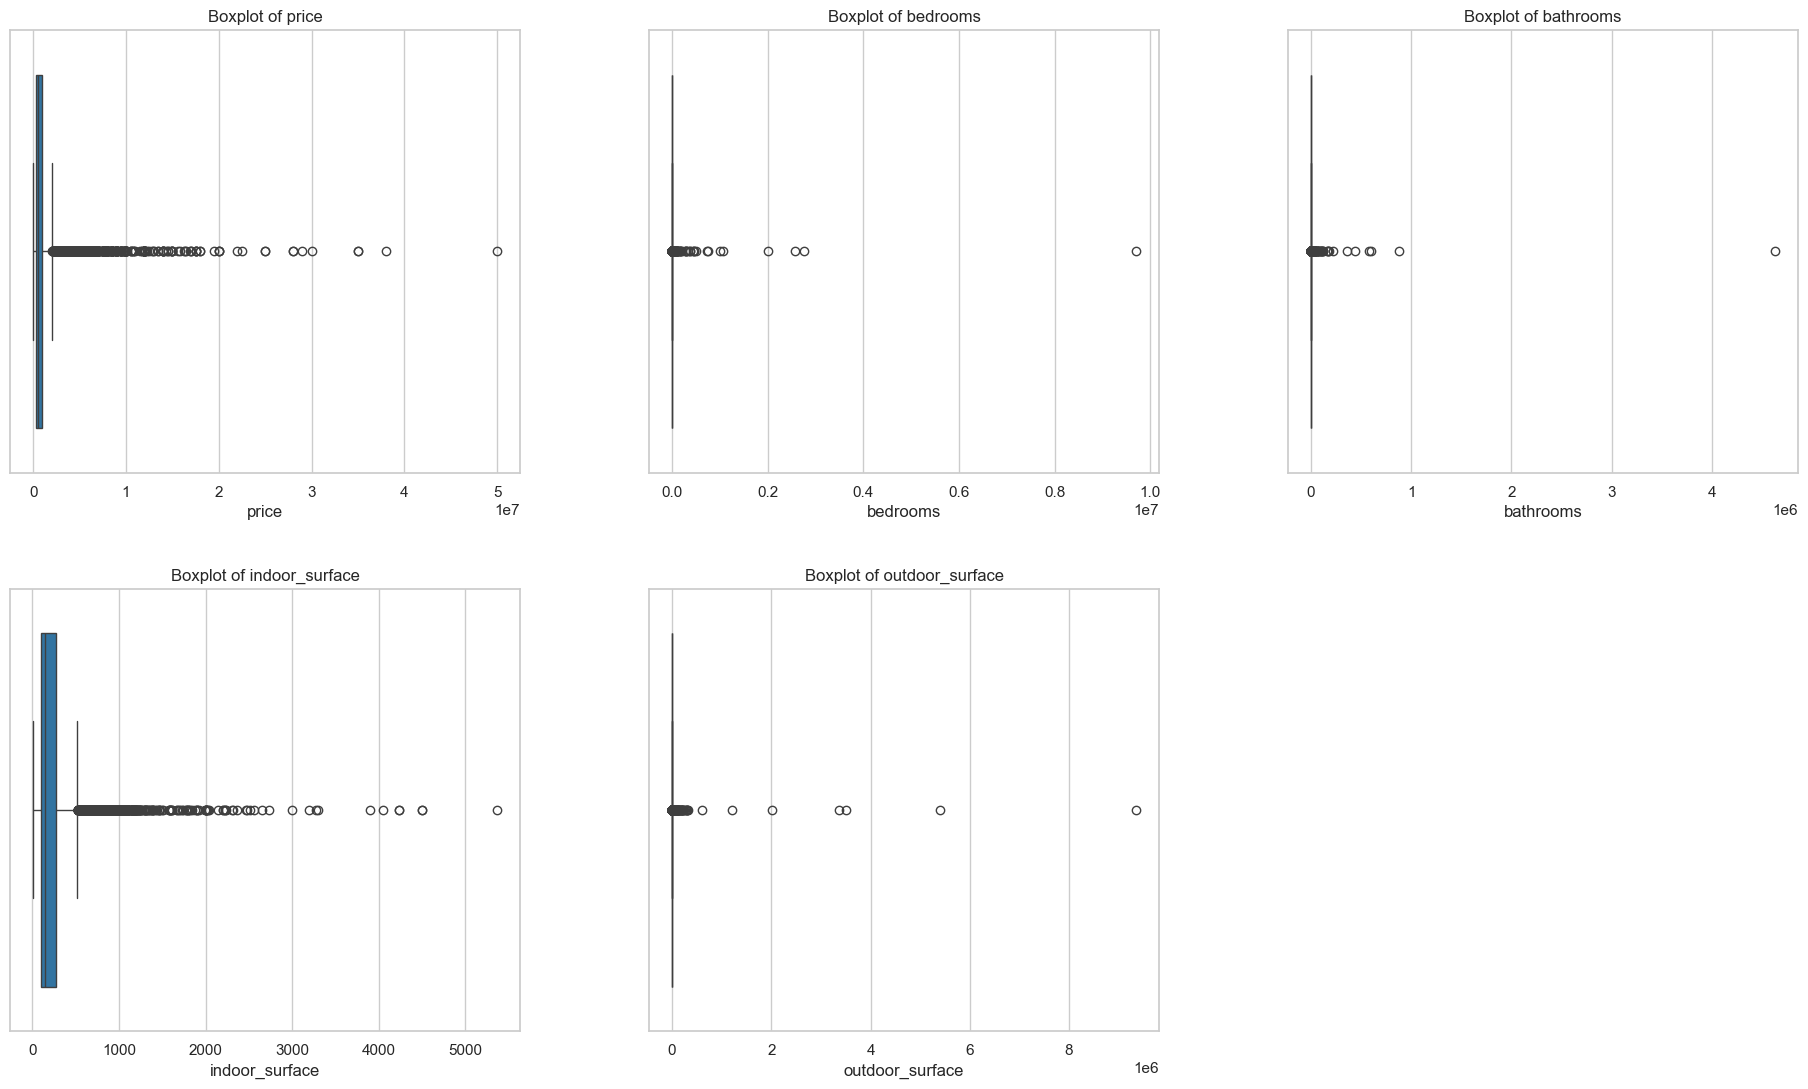

In [15]:
# --- 1. Check for Missing Values ---
print("--- 1. Missing Values Check ---")
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_values, missing_percentage], axis=1)
missing_table = missing_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

if missing_table[missing_table.iloc[:,0] != 0].empty:
    print("Congratulations! No missing values found.\n")
else:
    print("Found missing values in the following columns:\n")
    print(missing_table[missing_table.iloc[:,0] != 0].sort_values(
        '% of Total Values', ascending=False).round(2))

# --- 2. Check for Duplicate Rows ---
print("\n--- 2. Duplicate Rows Check ---")
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Found {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found.\n")

# --- 3. Check for Constant or Quasi-Constant Columns ---
print("\n--- 3. Constant Columns Check ---")
# Columns with only one unique value provide no information
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"The following columns have only 1 unique value (constant): {constant_cols}")
else:
    print("No constant columns found.")

# --- 4. Categorical Inconsistencies ---
print("\n--- 4. Categorical Data Quality ---")
# Check for potential data entry errors in object columns
for col in categoricalFeatures:
    if col not in df.columns: continue
    
    print(f"Analyzing '{col}':")
    
    # A. Check for Whitespace/Casing Duplicates
    # e.g., "Villa" vs "villa" or "Marbella " vs "Marbella"
    raw_uniques = df[col].dropna().unique()
    clean_uniques = df[col].dropna().str.strip().str.lower().unique()
    
    if len(raw_uniques) != len(clean_uniques):
        print(f"  [!] Potential inconsistencies found (case/whitespace differences).")
        print(f"      Original unique count: {len(raw_uniques)}, Cleaned unique count: {len(clean_uniques)}")
    
    # B. Check for Rare Labels (Typos)
    # Categories with very few observations might be typos of larger categories
    value_counts = df[col].value_counts()
    rare_labels = value_counts[value_counts < 2] # Appears only once
    if not rare_labels.empty:
        print(f"  [!] Found {len(rare_labels)} rare categories (appearing only once). Examples: {list(rare_labels.index[:5])}")
    else:
        print("  Good. No singleton categories found.")
    print("-" * 20)

# --- 5. Numerical Validity & Skewness ---
print("\n--- 5. Numerical Logic & Distribution ---")

# A. Negative Values Check
print("Checking for illogical negative values...")
impossible_negatives = ['price', 'indoor_surface', 'outdoor_surface', 'bedrooms', 'bathrooms']
for col in impossible_negatives:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f"  [!] Warning: '{col}' has {neg_count} negative values.")
        else:
            print(f"  '{col}' is clean (no negatives).")

# B. Skewness Check
print("\nChecking Skewness (Threshold: > 1 or < -1)...")
skewness = df[continuousFeatures].skew()
high_skew = skewness[abs(skewness) > 1]
if not high_skew.empty:
    print("The following variables are highly skewed (indicating potential outliers or non-normal distribution):")
    print(high_skew)
else:
    print("No highly skewed variables found.")

# --- 6. Outlier Detection (IQR) ---
print("\n--- 6. Outlier Detection (IQR Method) ---")
for col in continuousFeatures:
    valid_data = df[col].dropna()
    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
    
    if not outliers.empty:
        print(f"Outliers found in '{col}': {len(outliers)} ({len(outliers)/len(valid_data)*100:.1f}%)")
        print(f"  Range: {lower_bound:.2f} to {upper_bound:.2f}")
    else:
        print(f"No outliers found in '{col}'.")

print("\nGenerating boxplots for visual confirmation...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = axes.flatten()
for i in range(len(continuousFeatures)):
    col = continuousFeatures[i]
    sns.boxplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f"Boxplot of {col}")

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig('images/boxplots.pdf')
plt.show()

### Histograms

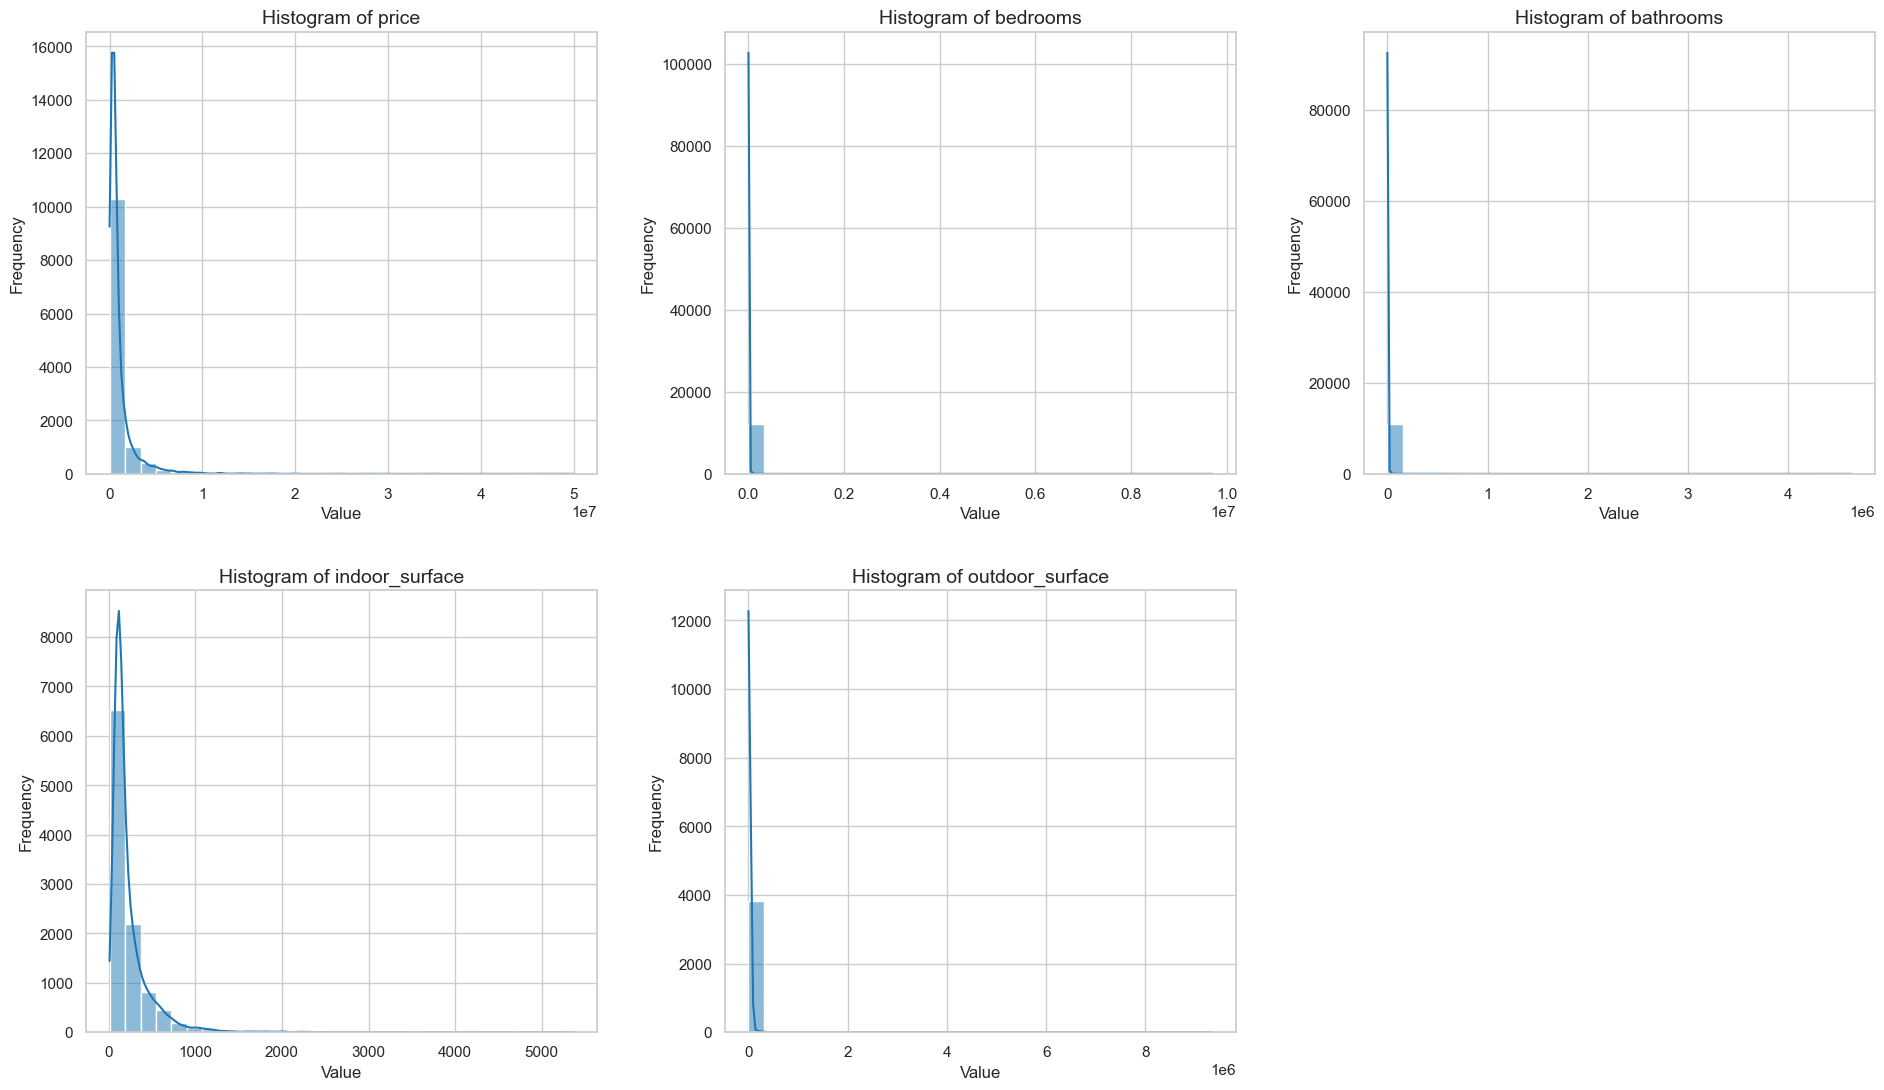

In [9]:
# We have 5 continuous features, so a 2x3 grid works well
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = ax.flatten()

for i in range(len(continuousFeatures)):
    current_feature = continuousFeatures[i]
    sns.histplot(data=df, x=current_feature, bins=30, kde=True, ax=ax[i])
    
    ax[i].set_title(f'Histogram of {current_feature}', fontsize=14)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')

# Hide unused subplots
for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig("images/histograms.pdf")
plt.show()

### Plot Relationships


Generating scatter plot for Indoor Surface vs. Price...


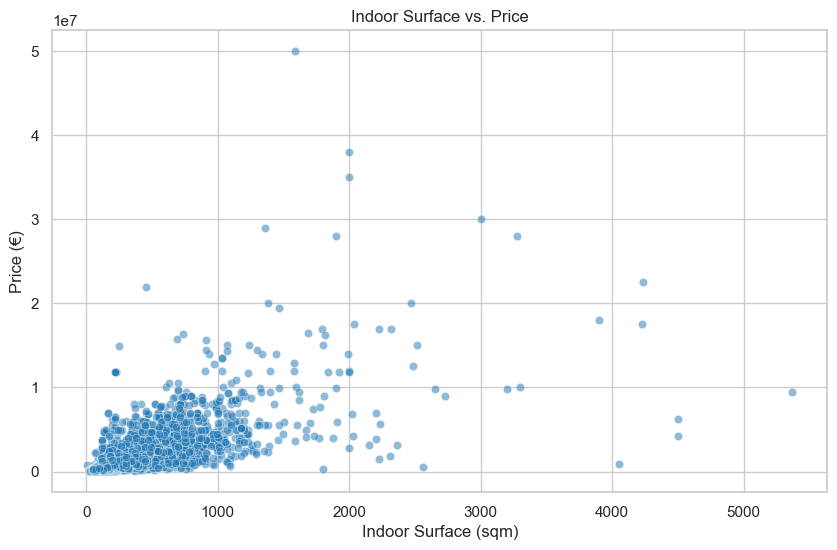


Generating box plot for Price vs Bedrooms...


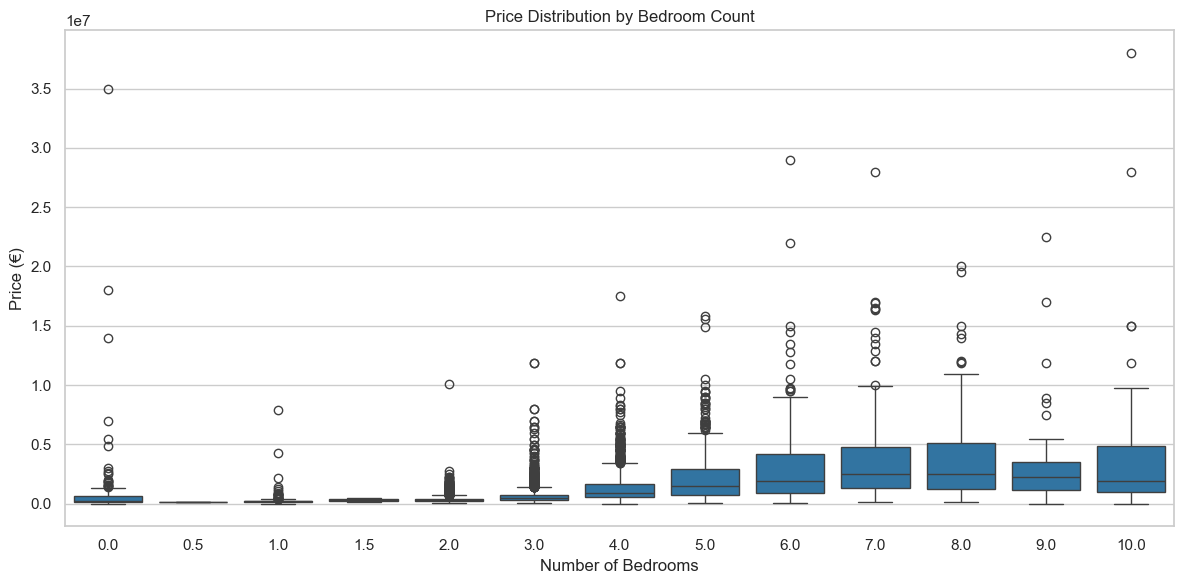


Generating bar plot for Top 10 Locations...


/tmp/ipykernel_819385/3996421095.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='location', data=df, order=top_locations, palette='viridis')


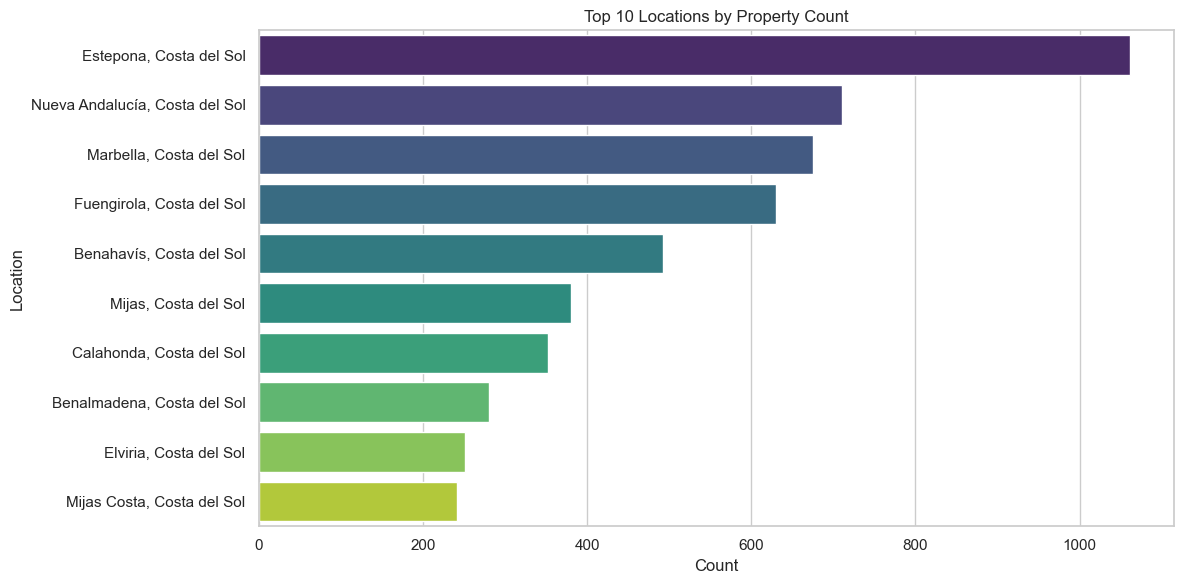

In [ ]:
# Scatter Plot (Specific Continuous vs. Continuous)
# Plot 1: Indoor Surface vs Price
print("\nGenerating scatter plot for Indoor Surface vs. Price...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='indoor_surface', y='price', alpha=0.5)
plt.xlabel('Indoor Surface (sqm)')
plt.ylabel('Price (€)')
plt.title('Indoor Surface vs. Price')
plt.savefig('images/scatter_surface_price.pdf')
plt.show()

# Box Plots (Categorical vs. Continuous)
# Analyzing Price distribution by Number of Bedrooms (treating bedrooms as categories for this view)
print("\nGenerating box plot for Price vs Bedrooms...")
plt.figure(figsize=(12, 6))
# Filter to reasonable bedroom counts (e.g., <= 10) to keep plot readable
subset_df = df[df['bedrooms'] <= 10]
sns.boxplot(x='bedrooms', y='price', data=subset_df)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (€)')
plt.title('Price Distribution by Bedroom Count')
plt.tight_layout()
plt.savefig('images/price_vs_bedrooms.pdf')
plt.show()

# Bar Plot (Categorical Counts)
# Analyzing top locations
print("\nGenerating bar plot for Top 10 Locations...")
top_locations = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.countplot(y='location', data=df, order=top_locations, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 10 Locations by Property Count')
plt.tight_layout()
plt.savefig('images/top_locations.pdf')
plt.show()

### Pair Plots

Generating pairplot for all continuous variables...


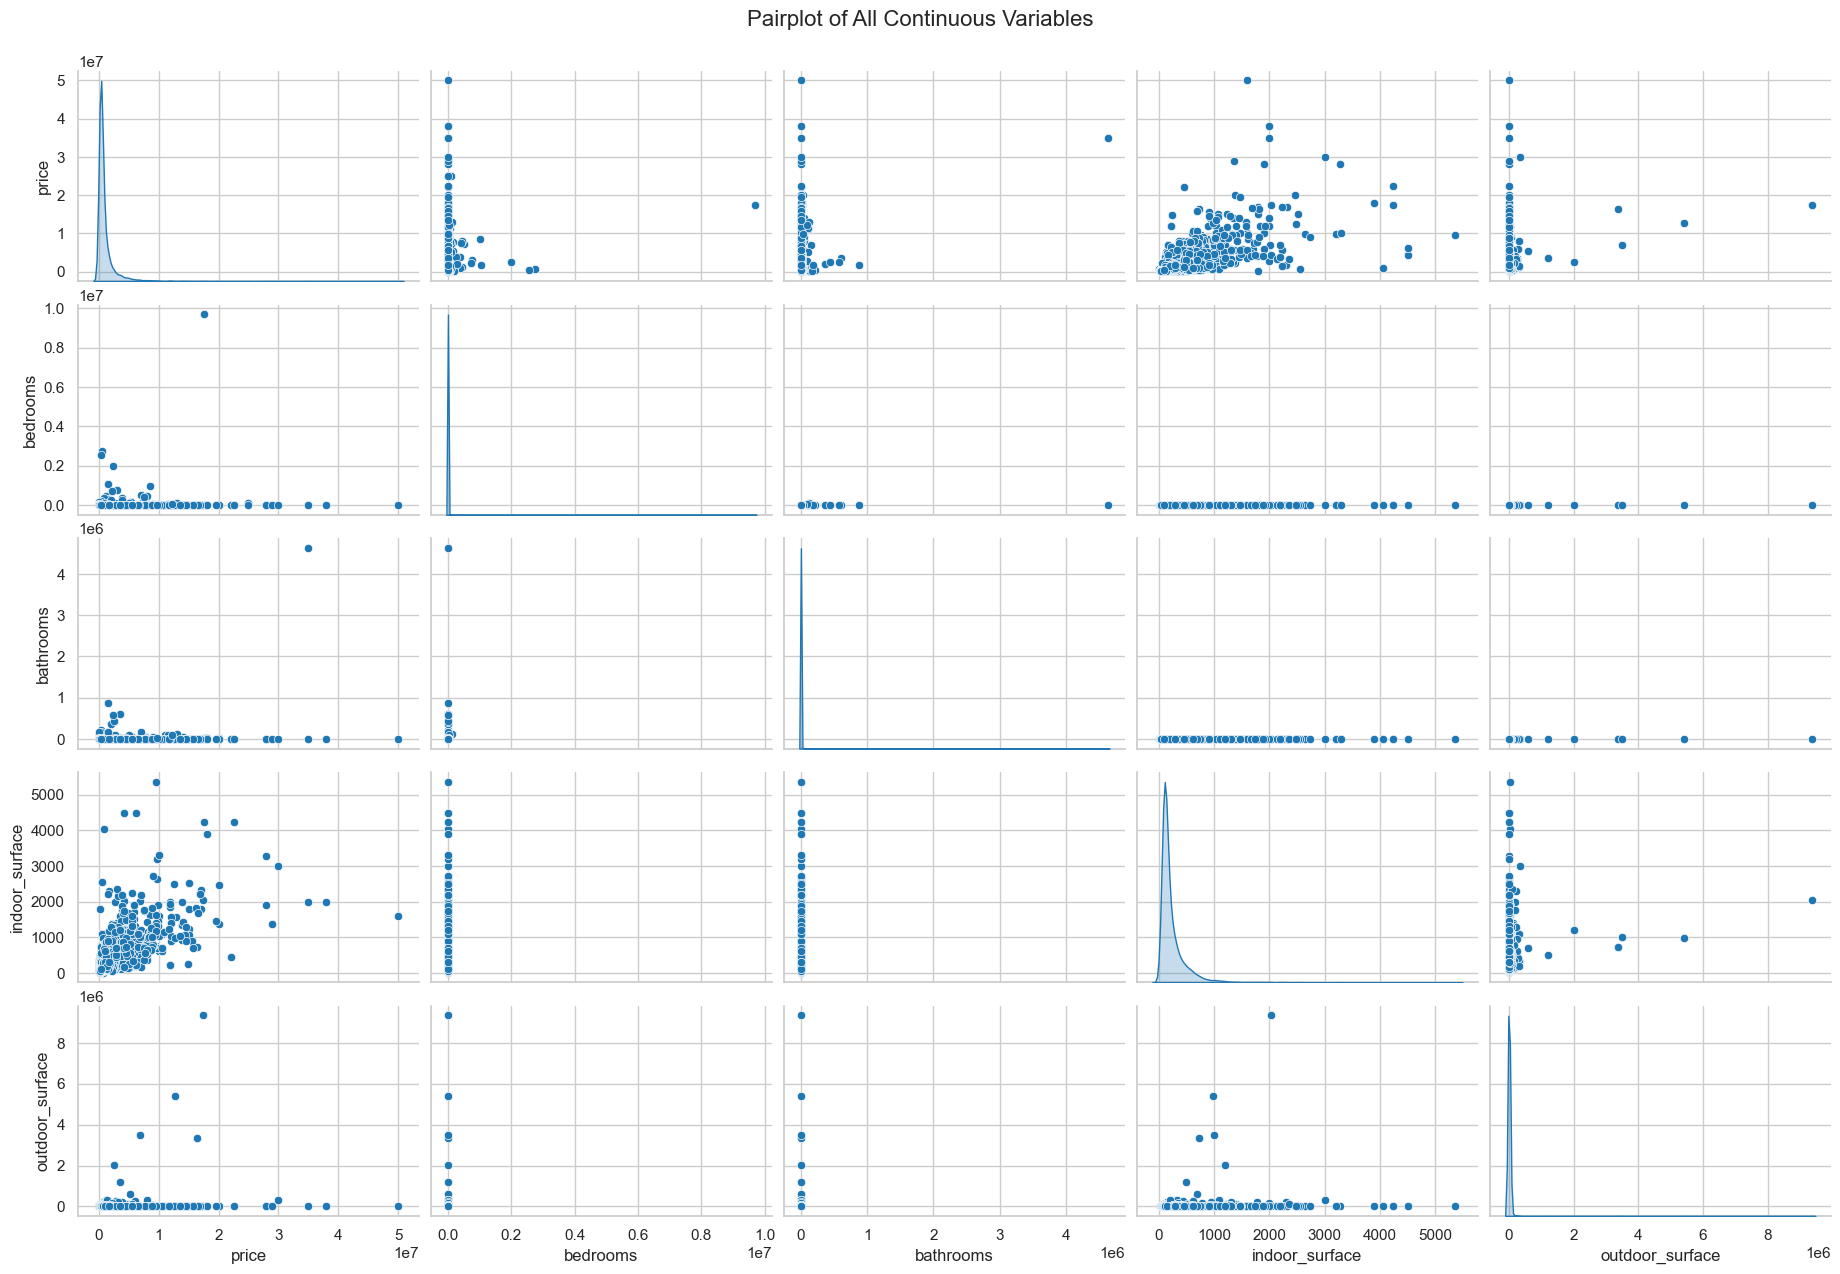

Generating count plots for all categorical variables...


/tmp/ipykernel_819385/3214680902.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


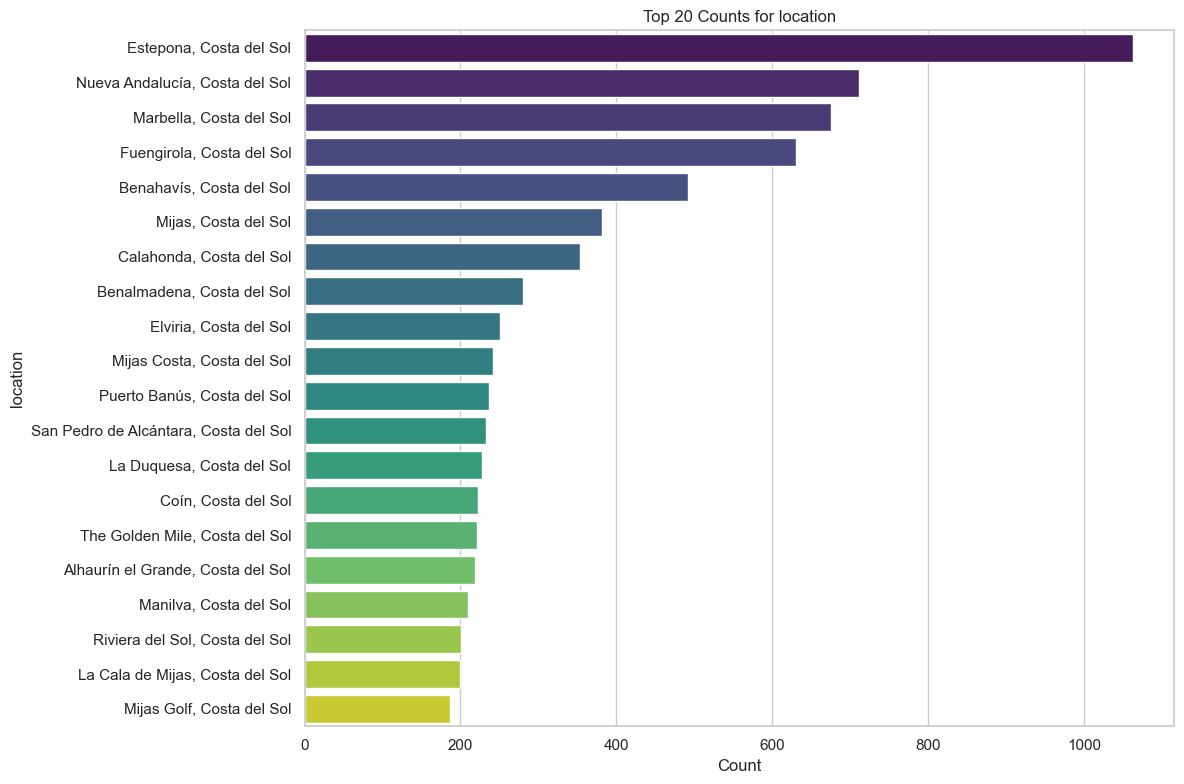

/tmp/ipykernel_819385/3214680902.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')


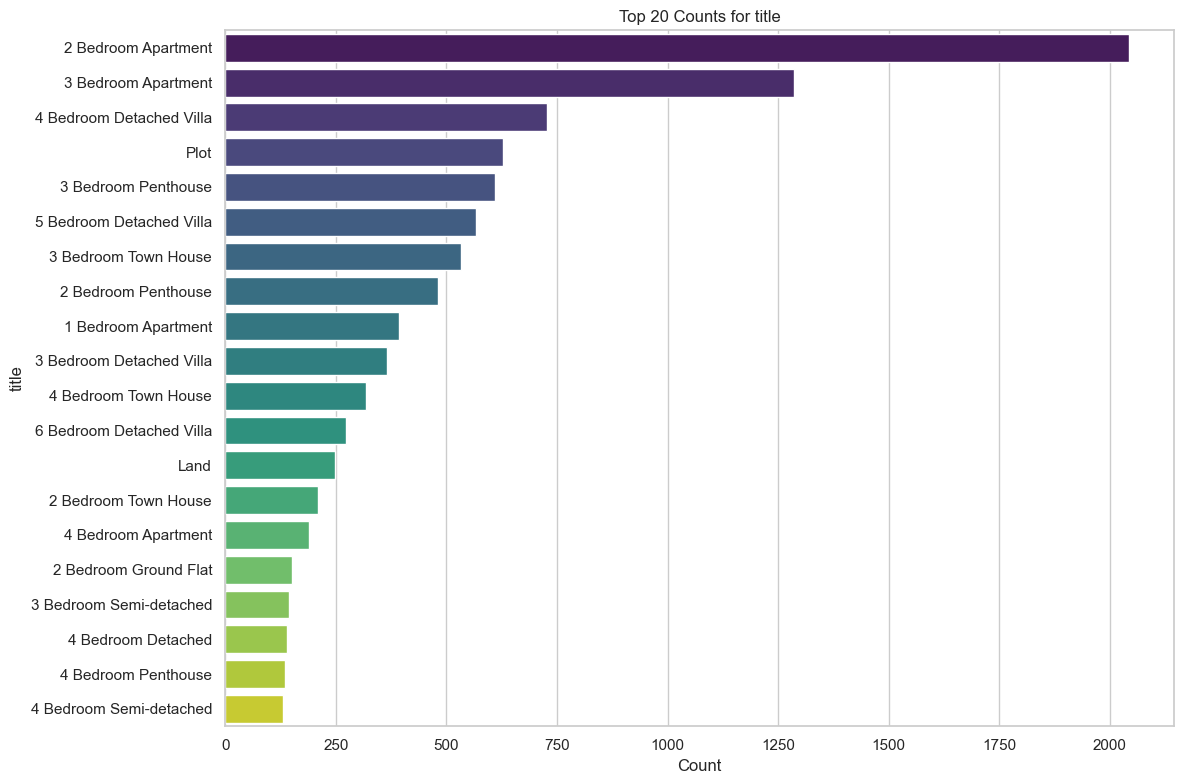

/tmp/ipykernel_819385/3214680902.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_categories, palette='viridis')
/tmp/ipykernel_819385/3214680902.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


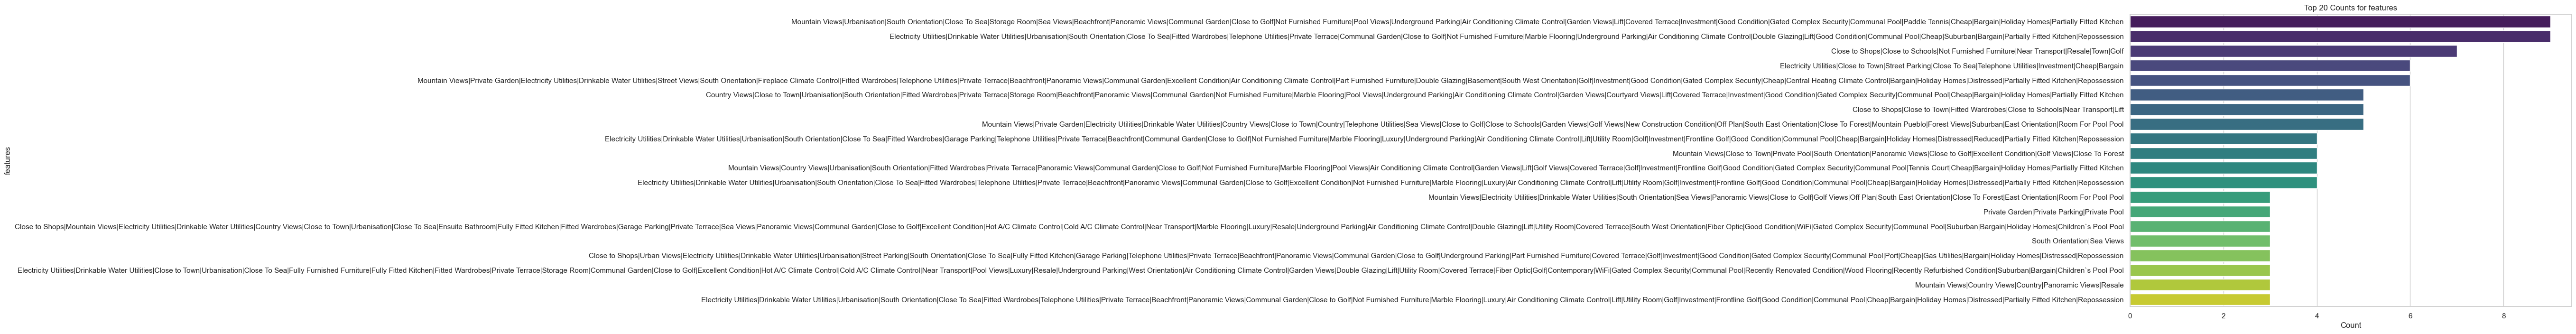

In [14]:
# --- Pairplot for ALL Continuous Variables ---
print("Generating pairplot for all continuous variables...")
sns.pairplot(df[continuousFeatures], aspect=1.5, diag_kind='kde')
plt.suptitle('Pairplot of All Continuous Variables', y=1.02, fontsize=16)
plt.savefig('images/pairplot_all.png')
plt.show()

# --- Count Plots for ALL Categorical Variables ---
print("Generating count plots for all categorical variables...")

# We will limit to top 20 for readability because 'location' and 'features' likely have high cardinality
for col in categoricalFeatures:
    plt.figure(figsize=(12, 8))
    
    # Get top 20 categories to keep the plot readable
    top_categories = df[col].value_counts().nlargest(20).index
    
    sns.countplot(y=col, data=df, order=top_categories, palette='viridis')
    plt.title(f'Top 20 Counts for {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(f'images/countplot_{col}.png')
    plt.show()

### Correlation Matrix

Covariance Matrix:
                        price      bedrooms     bathrooms  indoor_surface  \
price            3.539282e+12  1.617749e+10  1.559039e+10    3.447684e+08   
bedrooms         1.617749e+10  9.708442e+09  4.182144e+06    3.705881e+02   
bathrooms        1.559039e+10  4.182144e+06  2.149698e+09    3.710090e+02   
indoor_surface   3.447684e+08  3.705881e+02  3.710090e+02    7.025941e+04   
outdoor_surface  7.680312e+10  1.999662e+04  2.134321e+04    7.401787e+06   

                 outdoor_surface  
price               7.680312e+10  
bedrooms            1.999662e+04  
bathrooms           2.134321e+04  
indoor_surface      7.401787e+06  
outdoor_surface     3.844150e+10  


Calculating Pearson's Correlation...


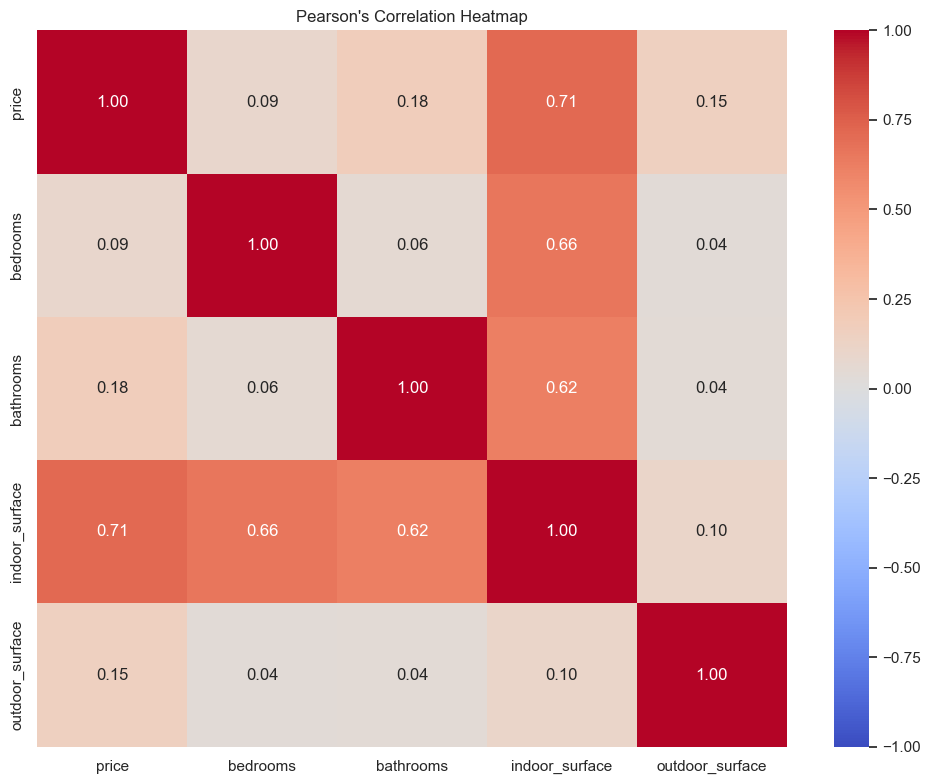

Calculating Spearman's Correlation...


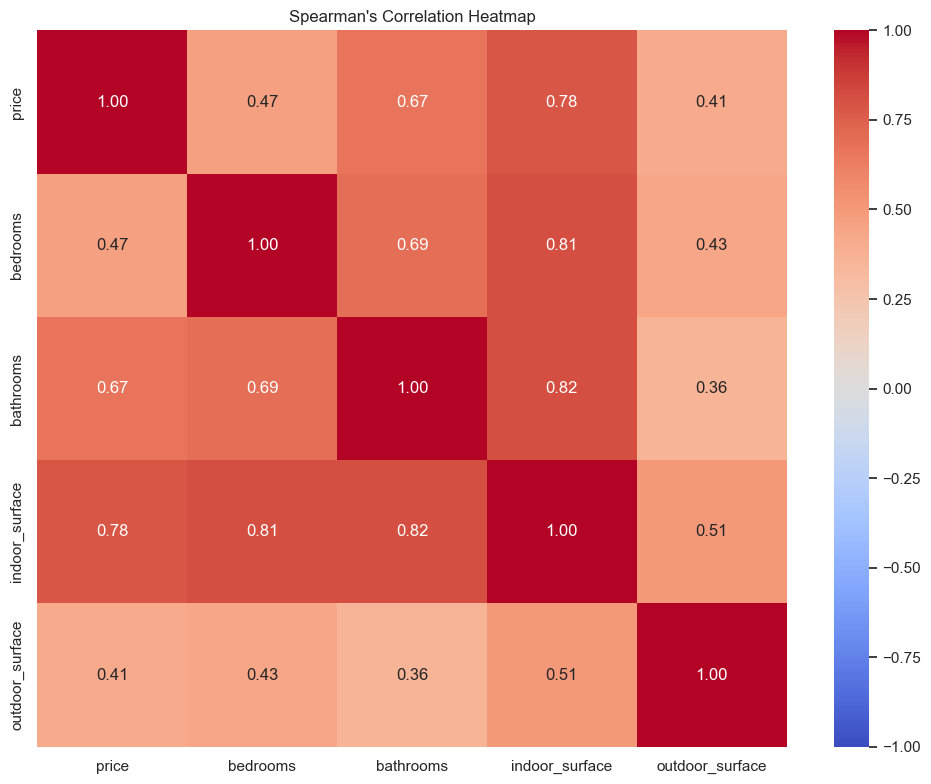

In [11]:
print("Covariance Matrix:")
covariance = df[continuousFeatures].cov()
print(covariance)
print("\n" + "="*80 + "\n") 

# --- Pearson's Correlation ---
# For variables with a linear relationship
print("Calculating Pearson's Correlation...")
plt.figure(figsize=(10, 8))
correlation = df[continuousFeatures].corr(method='pearson')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/pearson_correlation.pdf')
plt.show()

# --- Spearman's Correlation ---
# For variables with a monotonic relationship (useful if price/surface are skewed)
print("Calculating Spearman's Correlation...")
plt.figure(figsize=(10, 8))
correlationSp = df[continuousFeatures].corr(method='spearman')
sns.heatmap(correlationSp, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/spearman_correlation.pdf')
plt.show()

# Data Prep